In [22]:
from transformers import AutoTokenizer

model_path = 'FacebookAI/xlm-roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_path)

In [23]:
from datasets import load_dataset, Dataset, DatasetDict, Features, Sequence, Value
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load your CSV file into a Hugging Face Dataset
dataset = load_dataset('csv', data_files='df_gb.csv')['train']

all_labels = set()
label_column = 'labels'

for labels_str in dataset[label_column]:
    if pd.isna(labels_str):  # handle empty/NaN
        continue
    # Safely evaluate the string as a list (assuming it's like "['A', 'B']")
    try:
        labels = [lbl.strip() for lbl in eval(labels_str) if isinstance(lbl, str) and lbl.strip()]
    except:
        labels = []
    all_labels.update(labels)

classes = sorted(all_labels)
class2id = {class_: idx for idx, class_ in enumerate(classes)}
id2class = {idx: class_ for class_, idx in class2id.items()}

print("Classes:", classes)

# 3. Convert labels to multi-hot binary vectors
def labels_to_multihot(example):
    labels_str = example[label_column]
    label_list = []
    if not pd.isna(labels_str) and str(labels_str).strip() != '':
        try:
            # Try to eval if it's a list representation
            raw_labels = eval(labels_str)
            if isinstance(raw_labels, list):
                label_list = [lbl.strip() for lbl in raw_labels if isinstance(lbl, str) and lbl.strip()]
            else:
                # Fallback: treat as comma-separated string
                label_list = [lbl.strip() for lbl in str(labels_str).split(',') if lbl.strip()]
        except:
            # If eval fails, treat as comma-separated
            label_list = [lbl.strip() for lbl in str(labels_str).split(',') if lbl.strip()]
    
    multihot = [0] * len(classes)
    for lbl in label_list:
        if lbl in class2id:
            multihot[class2id[lbl]] = 1
    return {'labels': multihot}

# Apply transformation
dataset = dataset.map(labels_to_multihot)

# 4. Convert to pandas for splitting
df = dataset.to_pandas()

# 5. Split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 6. Define features with multi-label support
# Assuming your other columns are text (e.g., 'text'), adjust as needed
# Here we assume the dataset has at least a 'text' column and the 'labels' column
other_columns = [col for col in df.columns if col != 'labels']
features = Features({
    **{col: Value("string") for col in other_columns},  # adjust dtype if needed (e.g., "int32", "float32")
    'labels': Sequence(Value("float32"))  # multi-hot vector: list of integers (0/1)
})

# 7. Convert back to Dataset with explicit features
train_dataset = Dataset.from_pandas(train_df, features=features, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, features=features, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, features=features, preserve_index=False)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

Classes: ['cash_operations_and_transfers', 'consumer_loans_and_installment_plan', 'credit_card_and_account_management', 'customer_support_and_additional_services', 'debit_card_and_account_management', 'digital_banking_platforms', 'investments_and_financial_products', 'legal_and_administrative_issues', 'mortgage_loans_and_installment_plans', 'other', 'payment_cards_and_digital_payments', 'payments_and_fees', 'premium_banking_services', 'rewards_and_benefits', 'social_benefits_and_government_payments']
DatasetDict({
    train: Dataset({
        features: ['url', 'review_tag', 'date_review', 'user_name', 'user_city', 'review_title', 'review_text', 'review_status', 'rating', 'bank_name', 'source', 'review_text_cleaned', 'review_text_lemmatized', 'labels'],
        num_rows: 492
    })
    validation: Dataset({
        features: ['url', 'review_tag', 'date_review', 'user_name', 'user_city', 'review_title', 'review_text', 'review_status', 'rating', 'bank_name', 'source', 'review_text_cleaned

In [24]:
import torch

def preprocess_function(example):
   text = example['review_text']
   example = tokenizer(text, truncation=True)
   return example

tokenized_dataset = dataset.map(preprocess_function)

Map: 100%|██████████| 106/106 [00:00<00:00, 1290.47 examples/s]


In [25]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


In [37]:
import evaluate
import numpy as np

clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))


In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
   model_path, num_labels=len(classes),
           id2label=id2class, label2id=class2id,
                       problem_type = "multi_label_classification")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import os

os.environ["TORCH_USE_CUDA_DSA"]="1"
os.environ["TOKENIZERS_PARALLELISM"]="1"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [ ]:
import datetime
current_datetime = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")


training_args = TrainingArguments(
    output_dir=f"my_awesome_model_{current_datetime}",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    lr_scheduler_type="linear",  
    warmup_ratio=0.1,      
    metric_for_best_model="f1",
    greater_is_better=True,          
)
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   processing_class=tokenizer,	
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.454712,0.864127,0.351515,0.552381,0.257778
2,No log,0.349555,0.864127,0.351515,0.552381,0.257778
3,No log,0.335809,0.878095,0.372549,0.703704,0.253333
4,0.462700,0.315987,0.888254,0.439490,0.775281,0.306667
5,0.462700,0.294346,0.883175,0.428571,0.711340,0.306667
6,0.462700,0.269150,0.900952,0.541176,0.800000,0.408889
7,0.309100,0.243435,0.911111,0.590643,0.863248,0.448889
8,0.309100,0.223147,0.920000,0.659459,0.841379,0.542222
9,0.309100,0.217460,0.919365,0.664908,0.818182,0.560000
10,0.214800,0.200680,0.928254,0.716792,0.821839,0.635556


TrainOutput(global_step=8200, training_loss=0.09020410169915455, metrics={'train_runtime': 1806.8881, 'train_samples_per_second': 13.615, 'train_steps_per_second': 4.538, 'total_flos': 3890420469453492.0, 'train_loss': 0.09020410169915455, 'epoch': 50.0})

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f5a36e22000>>
Traceback (most recent call last):
  File "/home/lockr/projects/LCT_hackaton/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch,Training Loss,Validation Loss


In [ ]:

# Оценка на validation
print("Evaluating on validation set...")
val_results = trainer.predict(tokenized_dataset["validation"])
print("Validation metrics:", val_results.metrics)

# Оценка на test
print("Evaluating on test set...")
test_results = trainer.predict(tokenized_dataset["test"])
print("Test metrics:", test_results.metrics)

Evaluating on validation set...


Validation metrics: {'test_loss': 0.18213048577308655, 'test_accuracy': 0.9371428571428572, 'test_f1': 0.7681498829039812, 'test_precision': 0.8118811881188119, 'test_recall': 0.7288888888888889, 'test_runtime': 1.5594, 'test_samples_per_second': 67.335, 'test_steps_per_second': 22.445}
Evaluating on test set...


Test metrics: {'test_loss': 0.21272651851177216, 'test_accuracy': 0.9276729559748428, 'test_f1': 0.7344110854503464, 'test_precision': 0.7794117647058824, 'test_recall': 0.6943231441048034, 'test_runtime': 1.6188, 'test_samples_per_second': 65.479, 'test_steps_per_second': 22.238}


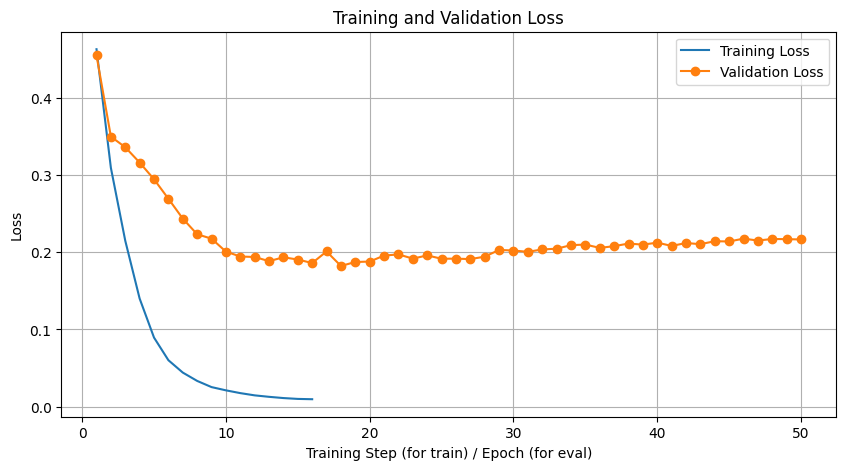

In [ ]:
import matplotlib.pyplot as plt

# Extract logs
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs = []

for log in log_history:
    if 'loss' in log:  # training step log
        train_loss.append(log['loss'])
        # Note: training logs don't always have 'epoch', but eval logs do
    if 'eval_loss' in log:  # evaluation log (at end of epoch)
        eval_loss.append(log['eval_loss'])
        epochs.append(log['epoch'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, label="Training Loss")
# For eval loss, we align by epoch
plt.plot(epochs, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Training Step (for train) / Epoch (for eval)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
import json
import os
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

output_dir = "/home/lockr/projects/LCT_hackaton/research/my_awesome_model"


# 1. Читаем логи
with open(os.path.join(output_dir, "checkpoint-8200/trainer_state.json")) as f:
    logs = json.load(f)["log_history"]

# 2. Ищем лучший по eval_loss
eval_entries = [e for e in logs if "eval_loss" in e]
if not eval_entries:
    raise ValueError("Нет записей с eval_loss! Убедитесь, что использовали eval_dataset.")

best = min(eval_entries, key=lambda x: x["eval_loss"])
best_step = best["step"]

# 3. Загружаем
best_model_path = os.path.join(output_dir, f"checkpoint-{best_step}")
model = AutoModelForSequenceClassification.from_pretrained(best_model_path)

print(f"✅ Загружена лучшая модель (шаг {best_step}, eval_loss={best['eval_loss']:.4f})")

✅ Загружена лучшая модель (шаг 2952, eval_loss=0.1821)


In [34]:
trainer = Trainer(
   model=model,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   processing_class=tokenizer,	
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [35]:
# Оценка на test
print("Evaluating on test set...")
test_results = trainer.predict(tokenized_dataset["test"])
print("Test metrics:", test_results.metrics)

Evaluating on test set...


Test metrics: {'test_loss': 0.21272653341293335, 'test_model_preparation_time': 0.0029, 'test_accuracy': 0.9276729559748428, 'test_f1': 0.7344110854503464, 'test_precision': 0.7794117647058824, 'test_recall': 0.6943231441048034, 'test_runtime': 0.7208, 'test_samples_per_second': 147.063, 'test_steps_per_second': 19.423}


In [40]:
len(classes)

15